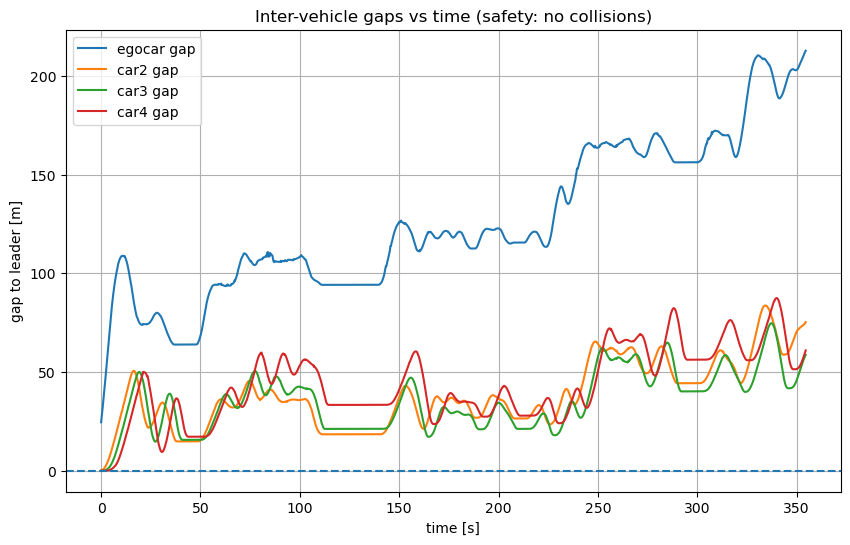

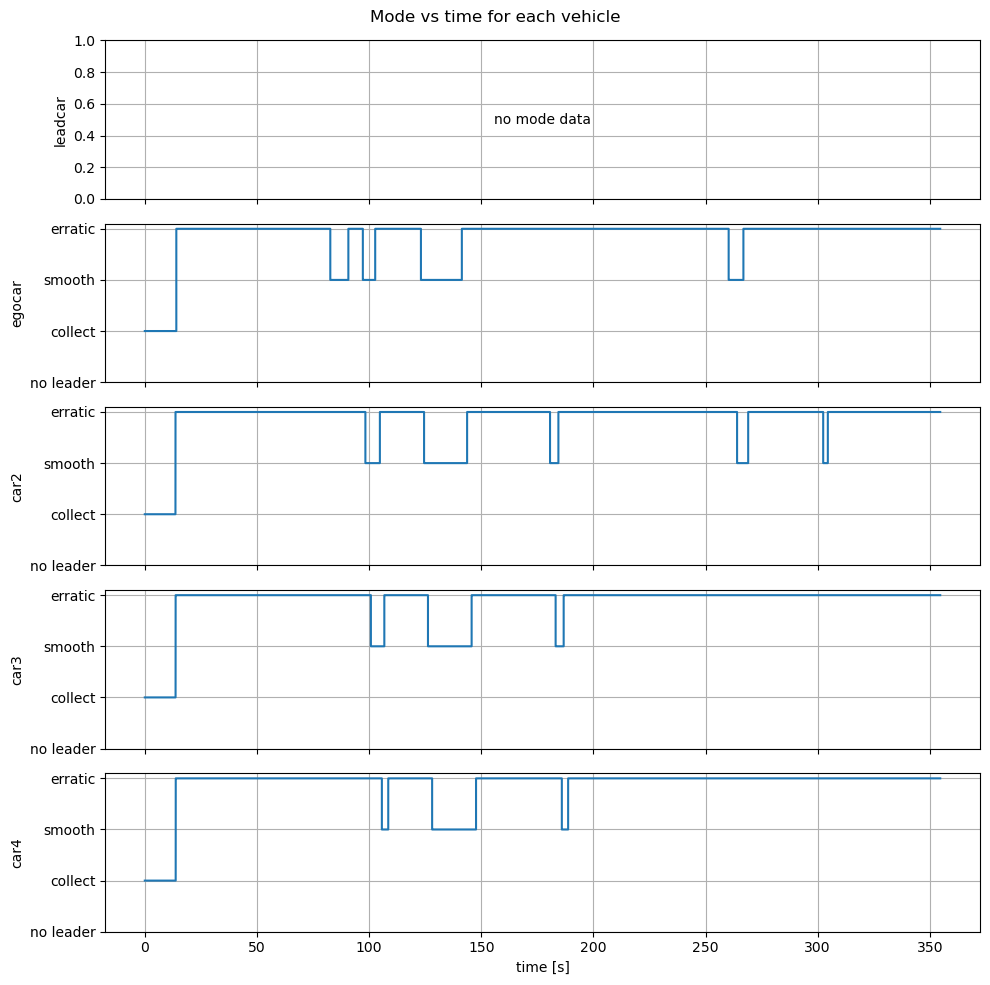

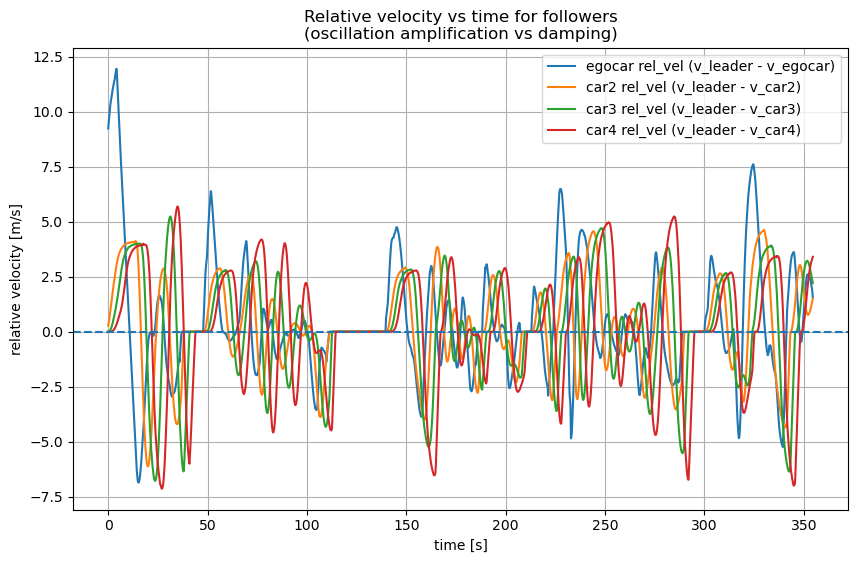


 Oscillation metrics (std of rel_vel)
egocar: std(rel_vel) = 2.638 m/s
car2: std(rel_vel) = 2.074 m/s
car3: std(rel_vel) = 2.414 m/s
car4: std(rel_vel) = 2.663 m/s


In [82]:
import rosbag
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

bag_path = "/Users/katiegildersleeve/cs3892/src/rossim/taketwo_2025-11-13-14-05-51.bag"
# Namespaces of vehicles in the platoon
lead_name = "leadcar"
follower_names = ["egocar", "car2", "car3", "car4"]
all_cars = [lead_name] + follower_names

# 1. Helper: extract scalar topic (std_msgs/Float32/Float64/Int/etc.)

def extract_scalar_topic(bag, topic):
    """
    Returns np.array of times (sec) and values for a scalar topic.
    Assumes message has a 'data' field (std_msgs/*).
    """
    ts = []
    vals = []
    for _, msg, t in bag.read_messages(topics=[topic]):
        ts.append(t.to_sec())
        if hasattr(msg, "data"):
            vals.append(msg.data)
        else:
            # Fallback: try to cast to float/int
            try:
                vals.append(float(msg))
            except Exception:
                raise RuntimeError(f"Message type for topic {topic} not supported.")
    if len(ts) == 0:
        return np.array([]), np.array([])
    ts = np.array(ts)
    vals = np.array(vals)
    # Ensure sorted by time
    order = np.argsort(ts)
    return ts[order], vals[order]

# 2. Read bag and collect raw signals

bag = rosbag.Bag(bag_path)

raw = {}  # raw[(car, signal)] -> (t, values)

# Velocity and odom_x (position) for each car, plus gap & rel_vel for followers
for car in all_cars:
    # vel_x
    topic_vel = f"/{car}/car/state/vel_x"
    t_v, v = extract_scalar_topic(bag, topic_vel)
    raw[(car, "vel")] = (t_v, v)

    # odom_x (position) from odometer node
    topic_x = f"/{car}/odom_x"
    try:
        t_x, x = extract_scalar_topic(bag, topic_x)
    except RuntimeError:
        t_x, x = np.array([]), np.array([])
    raw[(car, "x")] = (t_x, x)

for car in follower_names:
    # gap to leader (lead_dist)
    topic_gap = f"/{car}/lead_dist"
    t_g, g = extract_scalar_topic(bag, topic_gap)
    raw[(car, "gap")] = (t_g, g)

    # relative velocity (rel_vel)
    topic_rel = f"/{car}/rel_vel"
    t_r, r = extract_scalar_topic(bag, topic_rel)
    raw[(car, "rel_vel")] = (t_r, r)

# Modes (if published per vehicle, e.g. /egocar/mode, /car2/mode, ...)
for car in all_cars:
    topic_mode = f"/{car}/mode"
    try:
        t_m, m = extract_scalar_topic(bag, topic_mode)
    except RuntimeError:
        t_m, m = np.array([]), np.array([])
    raw[(car, "mode")] = (t_m, m)

bag.close()

# 3. Build common time axis and interpolate signals
#    Using lead car's velocity timestamps as the base

t_lead, v_lead = raw[(lead_name, "vel")]
if len(t_lead) == 0:
    raise RuntimeError("No leadcar velocity samples found; cannot build time axis.")

t0 = t_lead[0]
base_t = t_lead - t0  # relative time [s] starting from first lead sample

def interp_to_base(times, values, base_t_abs, fill_value=np.nan):
    """
    Interpolate a 1D signal (times, values) onto base_t_abs (absolute times).
    Returns an array with same shape as base_t_abs.
    """
    if len(times) == 0:
        return np.full_like(base_t_abs, np.nan, dtype=float)
    # Ensure sorted
    order = np.argsort(times)
    times = times[order]
    values = values[order]
    return np.interp(base_t_abs, times, values,
                     left=fill_value, right=fill_value)

# Build DataFrame indexed by relative time (seconds)
df = pd.DataFrame(index=base_t)
df.index.name = "t_rel"

# Lead car signals
df[f"vel_{lead_name}"] = v_lead
t_abs = t_lead  # absolute time axis corresponding to df.index + t0

# Add all other signals (interpolated to the leadcar time grid)
for car in all_cars:
    if car != lead_name:
        t_v, v = raw[(car, "vel")]
        df[f"vel_{car}"] = interp_to_base(t_v, v, t_abs)

    # Position
    t_x, x = raw[(car, "x")]
    if len(t_x) > 0:
        df[f"x_{car}"] = interp_to_base(t_x, x, t_abs)

    # Mode
    t_m, m = raw[(car, "mode")]
    if len(t_m) > 0:
        # Modes are integer states; use nearest neighbor via forward fill after simple interp
        m_interp = interp_to_base(t_m, m, t_abs)
        df[f"mode_{car}"] = np.round(m_interp).astype(float)  # keep NaN where no data

# Follower-only signals
for car in follower_names:
    # gap
    t_g, g = raw[(car, "gap")]
    df[f"gap_{car}"] = interp_to_base(t_g, g, t_abs)

    # relative velocity
    t_r, r = raw[(car, "rel_vel")]
    df[f"relvel_{car}"] = interp_to_base(t_r, r, t_abs)

# 4. Figure 1: ensure no car crashes into its leader
#    -> Plot lead_dist (gap) for each follower vs time

plt.figure(figsize=(10, 6))
for car in follower_names:
    col = f"gap_{car}"
    if col in df:
        plt.plot(df.index, df[col], label=f"{car} gap")

plt.axhline(0.0, linestyle="--")
plt.xlabel("time [s]")
plt.ylabel("gap to leader [m]")
plt.title("Inter-vehicle gaps vs time (safety: no collisions)")
plt.legend()
plt.grid(True)
plt.show()

# 5. Figure 2: each car's mode over time
#    -> Step-plot per vehicle

n_rows = len(all_cars)
fig, axes = plt.subplots(n_rows, 1, figsize=(10, 2 * n_rows), sharex=True)
if n_rows == 1:
    axes = [axes]

for i, car in enumerate(all_cars):
    ax = axes[i]
    col = f"mode_{car}"
    if col in df and not df[col].isna().all():
        ax.step(df.index, df[col], where="post")
        ax.set_ylabel(car)
        ax.set_yticks([1, 2, 3, 4])
        ax.set_yticklabels(["no leader", "collect", "smooth", "erratic"])
    else:
        ax.text(0.5, 0.5, "no mode data", ha="center", va="center", transform=ax.transAxes)
        ax.set_ylabel(car)
    ax.grid(True)

axes[-1].set_xlabel("time [s]")
fig.suptitle("Mode vs time for each vehicle")
plt.tight_layout()
plt.show()

# 6. Figure 3: oscillations amplification/damping
#    -> Plot rel_vel (v_leader - v_ego) for each follower
#       across the platoon and compare amplitudes

plt.figure(figsize=(10, 6))
for car in follower_names:
    col = f"relvel_{car}"
    if col in df and not df[col].isna().all():
        plt.plot(df.index, df[col], label=f"{car} rel_vel (v_leader - v_{car})")

plt.axhline(0.0, linestyle="--")
plt.xlabel("time [s]")
plt.ylabel("relative velocity [m/s]")
plt.title("Relative velocity vs time for followers\n(oscillation amplification vs damping)")
plt.legend()
plt.grid(True)
plt.show()

# Simple oscillation metric: standard deviation of rel_vel per follower
print("\n Oscillation metrics (std of rel_vel)")
for car in follower_names:
    col = f"relvel_{car}"
    if col in df and not df[col].isna().all():
        std_val = df[col].dropna().std()
        print(f"{car}: std(rel_vel) = {std_val:.3f} m/s")
